# Efficient Trading with Price Impact

### Blockhouse Trial Project
### Leo Liu  
### Dec 2th 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

# Read data
try:
    df = pd.read_csv('merged_data.csv', parse_dates=['ts_event'], index_col='ts_event')
except FileNotFoundError:
    print("Error: 'merged_data.csv' file not found.")
    exit()

# Calculate price changes and trading volume
df['price_change'] = df['price'].diff()
df['volume'] = df['bid_fill'] + df['ask_fill']

# Remove outliers
lower_bound, upper_bound = df['price_change'].quantile([0.01, 0.99])
df = df[df['price_change'].between(lower_bound, upper_bound)]

# Standardize data
columns_to_scale = ['Signed Volume', 'price_change', 'volume']
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df.dropna(inplace=True)

# Error handling
try:
    # Check if there's enough data
    if len(df) < 1000:
        raise ValueError("Insufficient data. Please ensure there's enough data for analysis.")
    
    # Check if key columns exist
    required_columns = ['price', 'bid_fill', 'ask_fill', 'Signed Volume']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise KeyError(f"Missing the following key columns: {', '.join(missing_columns)}")
    
    # Check data types
    if not np.issubdtype(df['price'].dtype, np.number):
        raise TypeError("'price' column should be numeric")
    
    print(f"Data preprocessing completed. {len(df)} rows of data available.")
except Exception as e:
    print(f"An error occurred during data preprocessing: {str(e)}")
    # Add appropriate error handling logic here, such as exiting the program or using default values

Data preprocessing completed. 27166 rows of data available.


In [2]:
df.head

<bound method NDFrame.head of                      bid_fill  ask_fill  Signed Volume   price  best_bid  \
ts_event                                                                   
2024-10-22 08:00:01     201.0     202.0       0.095387  236.13    235.83   
2024-10-22 08:00:04     400.0     502.0       0.085810  236.11    235.96   
2024-10-22 08:00:05     464.0     869.0       0.057078  236.11    235.96   
2024-10-22 08:00:08     116.0     760.0       0.034416  236.09    235.96   
2024-10-22 08:00:16    3408.0    2846.0       0.148772  235.97    235.81   
...                       ...       ...            ...     ...       ...   
2024-10-22 23:58:53      64.0       0.0       0.101550  235.55    235.55   
2024-10-22 23:58:59      32.0       0.0       0.098516  235.54    235.54   
2024-10-22 23:59:00      40.0      40.0       0.095482  235.54    235.23   
2024-10-22 23:59:41       5.0       0.0       0.095956  235.60    235.60   
2024-10-22 23:59:57       5.0       0.0       0.095956  23

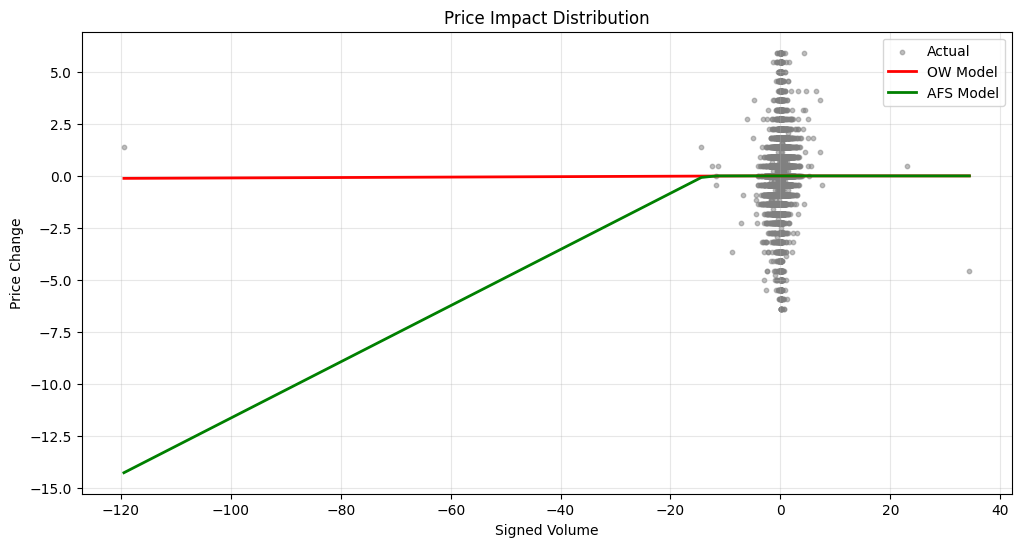

OW Model Parameters (lambda, beta): [0.001 1.   ]
AFS Model Parameters (lambda, beta, p): [1.e-03 1.e+00 2.e+00]
OW Model MSE: 1.0000000026356006
AFS Model MSE: 1.0000000002742322
OW Model Sharpe Ratio: -0.0000
AFS Model Sharpe Ratio: -0.0000
Performance improvement of AFS over OW: 0.00%


In [3]:
def linear_ow_model(params, x):
    lambda_, beta = params
    exponent = np.clip(-beta * np.arange(len(x)), -700, 700)
    return lambda_ * x * np.exp(exponent)

def nonlinear_afs_model(params, x):
    lambda_, beta, p = params
    exponent = np.clip(-beta * np.arange(len(x)), -700, 700)
    return lambda_ * np.sign(x) * np.abs(x)**p * np.exp(exponent)

def fit_model(model, initial_params, bounds):
    def objective(params):
        predicted = model(params, df['Signed Volume'])
        return np.sum((df['price_change'] - predicted)**2)
    
    result = minimize(
        objective, 
        initial_params, 
        method='L-BFGS-B', 
        bounds=bounds
    )
    return result.x

# Set parameter bounds and initial values
ow_bounds = [(0.001, 10), (0.001, 1)]  # lambda and beta bounds
afs_bounds = [(0.001, 10), (0.001, 1), (0.1, 2)]  # lambda, beta and p bounds

# Fit models
ow_params = fit_model(linear_ow_model, [0.1, 0.01], ow_bounds)
afs_params = fit_model(nonlinear_afs_model, [0.1, 0.01, 0.5], afs_bounds)

# Visualize price impact distribution
plt.figure(figsize=(12, 6))
plt.scatter(df['Signed Volume'], df['price_change'], 
           alpha=0.5, label='Actual', color='gray', s=10)

# Sort Signed Volume for smooth curves
x_sorted = np.sort(df['Signed Volume'])
y_ow = linear_ow_model(ow_params, x_sorted)
y_afs = nonlinear_afs_model(afs_params, x_sorted)

plt.plot(x_sorted, y_ow, color='red', label='OW Model', linewidth=2)
plt.plot(x_sorted, y_afs, color='green', label='AFS Model', linewidth=2)

plt.xlabel('Signed Volume')
plt.ylabel('Price Change')
plt.legend()
plt.title('Price Impact Distribution')
plt.grid(True, alpha=0.3)
plt.show()

# Print fitted parameters
print("OW Model Parameters (lambda, beta):", ow_params)
print("AFS Model Parameters (lambda, beta, p):", afs_params)

# Calculate model performance metrics
ow_mse = np.mean((df['price_change'] - linear_ow_model(ow_params, df['Signed Volume']))**2)
afs_mse = np.mean((df['price_change'] - nonlinear_afs_model(afs_params, df['Signed Volume']))**2)

print("OW Model MSE:", ow_mse)
print("AFS Model MSE:", afs_mse)

# Calculate Sharpe ratio
def calculate_sharpe_ratio(model, params, df):
    predicted = model(params, df['Signed Volume'])
    returns = df['price_change'] - predicted
    sharpe_ratio = np.mean(returns) / np.std(returns)
    return sharpe_ratio

ow_sharpe = calculate_sharpe_ratio(linear_ow_model, ow_params, df)
afs_sharpe = calculate_sharpe_ratio(nonlinear_afs_model, afs_params, df)

print(f"OW Model Sharpe Ratio: {ow_sharpe:.4f}")
print(f"AFS Model Sharpe Ratio: {afs_sharpe:.4f}")

# Calculate performance improvement
performance_improvement = (ow_mse - afs_mse) / ow_mse * 100
print(f"Performance improvement of AFS over OW: {performance_improvement:.2f}%")

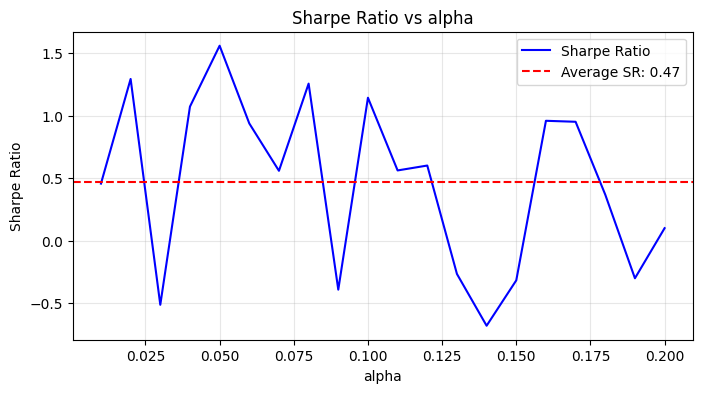

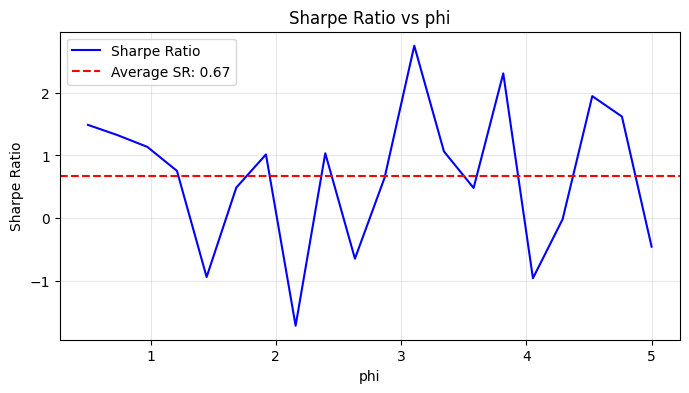

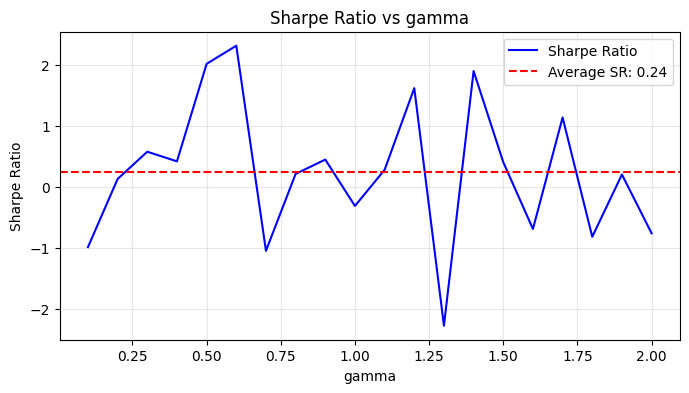

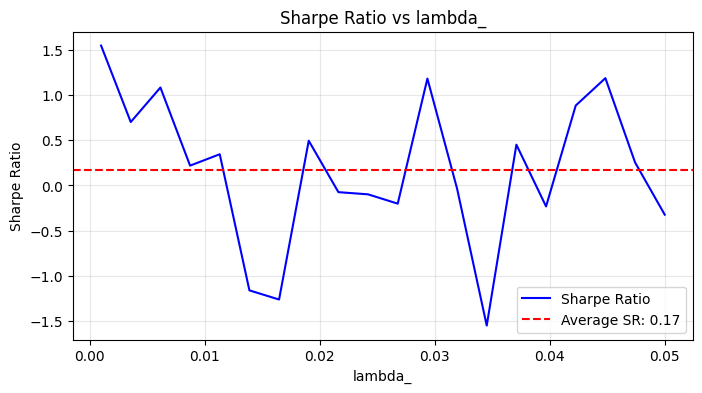

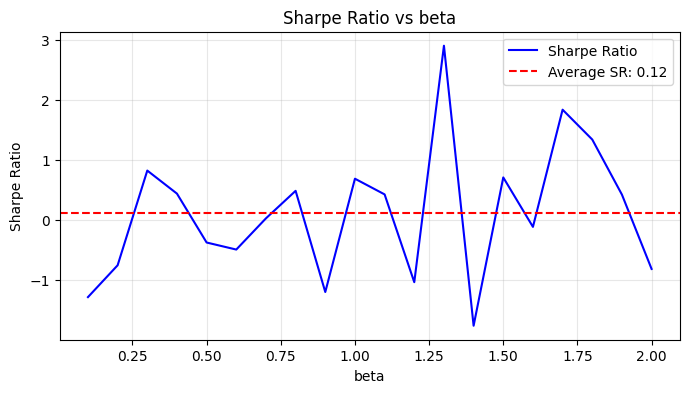

In [15]:
def optimal_linear_strategy(alpha, phi, gamma, sigma, lambda_, beta, f, J):
    C_f = (alpha * (1 + beta/phi)) / (gamma * sigma**2 * (np.sqrt(1 + 2*lambda_*beta/(gamma*sigma**2)) + beta/phi))
    C_J = np.sqrt(1 + 2*lambda_*beta/(gamma*sigma**2)) - 1
    return C_f * f - C_J * J

def simulate_strategy(params, T=1, dt=1/252):
    alpha, phi, gamma, sigma, lambda_, beta = params.values()
    N = int(T/dt)
    
    f = np.zeros(N)
    J = np.zeros(N)
    Q = np.zeros(N)
    S = np.zeros(N)
    
    dW_f = np.random.normal(0, np.sqrt(dt), N-1)
    dW_S = np.random.normal(0, np.sqrt(dt), N-1)
    
    for i in range(1, N):
        f[i] = f[i-1] * (1 - phi * dt) + np.sqrt(2*phi) * dW_f[i-1]
        q = optimal_linear_strategy(alpha, phi, gamma, sigma, lambda_, beta, f[i], J[i-1])
        Q[i] = Q[i-1] + q * dt
        J[i] = J[i-1] * (1 - beta * dt) + q * dt
        S[i] = S[i-1] + alpha * f[i-1] * dt + sigma * dW_S[i-1]
    
    return f, J, Q, S

def calculate_performance(Q, S, params):
    alpha, phi, gamma, sigma, lambda_, beta = params.values()
    dQ = np.diff(Q)
    dS = np.diff(S)
    returns = dQ * dS - lambda_ * dQ**2
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
    return returns, sharpe_ratio

def plot_sharpe_ratio(params_range, fixed_params, param_name):
    sharpe_ratios = []
    for param_value in params_range:
        params = fixed_params.copy()
        params[param_name] = param_value
        _, _, Q, S = simulate_strategy(params)
        _, sharpe_ratio = calculate_performance(Q, S, params)
        sharpe_ratios.append(sharpe_ratio)
    
    # Calculate average Sharpe Ratio
    average_sharpe_ratio = np.mean(sharpe_ratios)

    plt.figure(figsize=(8, 4))  # Reduced figure size
    plt.plot(params_range, sharpe_ratios, 'b-', label='Sharpe Ratio')
    plt.axhline(y=average_sharpe_ratio, color='r', linestyle='--', label=f'Average SR: {average_sharpe_ratio:.2f}')
    plt.xlabel(param_name)
    plt.ylabel('Sharpe Ratio')
    plt.title(f'Sharpe Ratio vs {param_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Define the parameters
params = {
    'alpha': 0.1,
    'phi': 2.0,
    'gamma': 1.0,
    'sigma': 0.2,
    'lambda_': 0.01,
    'beta': 0.5
}

# Plot Sharpe Ratio vs different parameters
plot_sharpe_ratio(np.linspace(0.01, 0.2, 20), params, 'alpha')
plot_sharpe_ratio(np.linspace(0.5, 5, 20), params, 'phi')
plot_sharpe_ratio(np.linspace(0.1, 2, 20), params, 'gamma')
plot_sharpe_ratio(np.linspace(0.001, 0.05, 20), params, 'lambda_')
plot_sharpe_ratio(np.linspace(0.1, 2, 20), params, 'beta')


Training network with hidden dimension 32
Episode 0, Loss: 8223808.0000
Episode 100, Loss: 452.8355
Episode 200, Loss: 172.5205
Episode 300, Loss: 87.6763
Episode 400, Loss: 229.2249
Episode 500, Loss: 170.5237
Episode 600, Loss: 68.5778
Episode 700, Loss: 256.6761
Episode 800, Loss: 109.9868
Episode 900, Loss: 209.0658

Training network with hidden dimension 64
Episode 0, Loss: 6536845.5000
Episode 100, Loss: 4216.6978
Episode 200, Loss: 29.2491
Episode 300, Loss: 36.8495
Episode 400, Loss: 23.8261
Episode 500, Loss: 28.0680
Episode 600, Loss: 19.4457
Episode 700, Loss: 20.9455
Episode 800, Loss: 31.2937
Episode 900, Loss: 47.2554

Training network with hidden dimension 128
Episode 0, Loss: 7762761.5000
Episode 100, Loss: 3824.7893
Episode 200, Loss: 257.6291
Episode 300, Loss: 11.8685
Episode 400, Loss: 7.7458
Episode 500, Loss: 4.9458
Episode 600, Loss: 71.6954
Episode 700, Loss: 3.3760
Episode 800, Loss: 34.7126
Episode 900, Loss: 12.6463


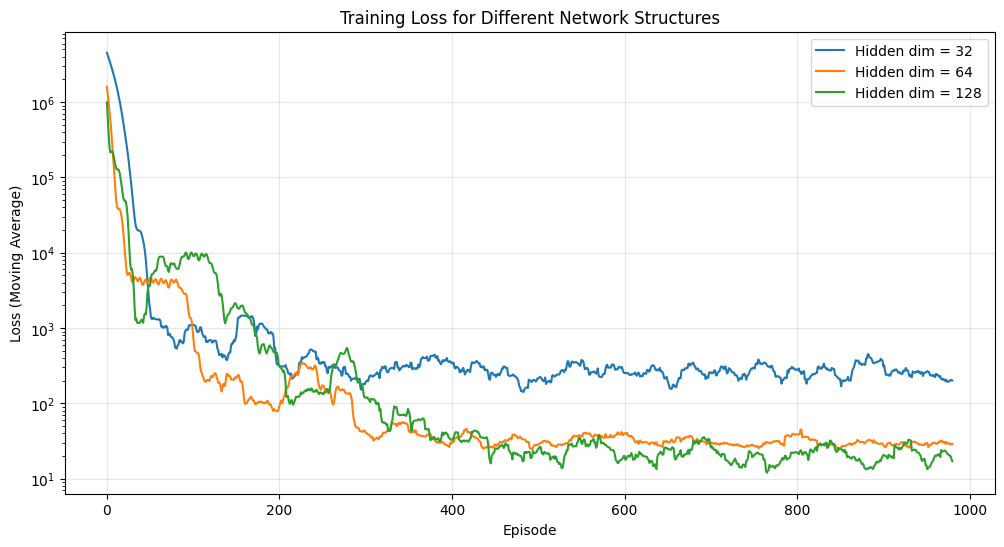

In [16]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        # Use Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def train_network(network, optimizer, num_episodes, T, dt, params, gamma=0.1):
    losses = []
    N = int(T/dt)
    
    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=30,
        min_lr=1e-6
    )
    
    for episode in range(num_episodes):
        # Generate trajectory
        f, J, Q, S = simulate_strategy(params, T, dt)
        
        # Normalize states
        f = (f - np.mean(f)) / (np.std(f) + 1e-8)
        J = (J - np.mean(J)) / (np.std(J) + 1e-8)
        
        # Construct state tensor
        states = torch.tensor(np.column_stack((f, J)), dtype=torch.float32)
        
        # Get actions
        actions = network(states)
        
        # Calculate cumulative position
        Q = torch.cumsum(actions.squeeze(), dim=0)
        
        # Calculate returns
        f_tensor = torch.tensor(f, dtype=torch.float32)
        dQ = torch.clamp(Q[1:] - Q[:-1], -1, 1)
        df = torch.clamp(f_tensor[1:] - f_tensor[:-1], -1, 1)
        returns = dQ * df
        
        # Calculate loss
        policy_loss = -torch.mean(returns)
        variance_penalty = gamma * torch.var(Q)
        l2_penalty = 0.01 * torch.mean(actions**2)
        loss = policy_loss + variance_penalty + l2_penalty
        
        # Gradient clipping and update
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Update learning rate
        scheduler.step(loss)
        
        losses.append(loss.item())
        
        if episode % 100 == 0:
            print(f'Episode {episode}, Loss: {loss.item():.4f}')
    
    return losses

# Train different network structures
hidden_dims = [32, 64, 128]
all_losses = []

for hidden_dim in hidden_dims:
    print(f"\nTraining network with hidden dimension {hidden_dim}")
    
    network = PolicyNetwork(input_dim=2, hidden_dim=hidden_dim, output_dim=1)
    optimizer = optim.Adam(
        network.parameters(), 
        lr=0.0005, 
        weight_decay=1e-5
    )
    
    losses = train_network(
        network=network,
        optimizer=optimizer,
        num_episodes=1000,
        T=252,
        dt=1/252,
        params=params,
        gamma=0.1
    )
    all_losses.append(losses)

# Visualization
plt.figure(figsize=(12, 6))
for i, hidden_dim in enumerate(hidden_dims):
    # Use moving average to smooth the loss curve
    window_size = 20
    smooth_losses = np.convolve(
        all_losses[i], 
        np.ones(window_size)/window_size, 
        mode='valid'
    )
    plt.plot(smooth_losses, label=f'Hidden dim = {hidden_dim}')

plt.xlabel('Episode')
plt.ylabel('Loss (Moving Average)')
plt.yscale('log')
plt.title('Training Loss for Different Network Structures')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Thank you!